In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import convolve
from scipy import stats
from sympy import symbols, solve

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
rng = np.random.default_rng()

### Intensity Decay Data Generation (convolution with Instrument Response Function)

In [3]:
def groupproject_IRFsimulate(amplitudes, lifetimes, acquisitiontime, irfwidth):
    bg = 10  # number of background counts per second, keep at 10
    if irfwidth == 0:
        irfwidth = 1e-8

    # check that each amplitude has a corresponding lifetime
    if len(amplitudes) != len(lifetimes):
        return

    # create empty vector to store decay data
    puredecay = np.zeros(381)

    # normalise amplitudes, just in case they didn't initially sum to 1
    amplitudes = amplitudes / np.sum(amplitudes)

    # generate a multiexponential decay starting at 1 at t=0
    # using the supplied amplitudes and lifetimes
    for i in range(381):
        t = (1/19) * (i - 1)  # each bin is (1/19) ns, starting at t=0
        for j in range(len(amplitudes)):
            puredecay[i] += amplitudes[j] * np.exp(-t / lifetimes[j])

    # generate the IRF, centred at b
    b = 10 / 19
    w = irfwidth
    irfraw = np.zeros(381)
    for i in range(381):
        t = (i - 1) * (1 / 19)
        irfraw[i] = np.exp(-4 * np.log(2) * (t - b)**2 / (w**2))

    # convolute the IRF and decay and trim to 381 bins
    Iconvol = convolve(puredecay, irfraw, mode='full')[:381]

    # we do our measurements at 2500 counts per second
    # calculate how many fluorescence counts per second this corresponds to
    # i.e. subtract background from total counts
    fluorate = 2500 - bg

    # calculate total number of fluorescence photons counted in measurement
    totalfluorescence = fluorate * acquisitiontime

    # now scale the multiexponential decay so it contains this many counts
    noiseless = totalfluorescence * Iconvol / np.sum(Iconvol)

    # and add on 'bg' counts per second spread evenly across all bins
    noiseless = noiseless + (bg * acquisitiontime / 381)

    # finally add Poisson noise to each bin
    noisydecay = np.random.poisson(noiseless)

    # and tidy up output with a time axis
    output = np.zeros((381,2))
    for i in range(381):
        output[i, 0] = (i - 1) * (1 / 19)
        output[i, 1] = noisydecay[i]

    return output


In [ ]:
from scipy import stats
from scipy.special import erf, erfinv
def sim_decay_photon_count_multiple(sim_param, Tau, N, n_decay):
    # n_decay is the number of decay to simulate

    # IRF parameters
    t0 = sim_param[0]    # offset in ns
    s = sim_param[1]    # standard deviation of Gaussian function in ns

    # Acquisition parameters
    n = sim_param[2]       # number of bits coding the TAC n = 8 --> 256 bins
    T = sim_param[3]      # Acquisition window 0-T in ns
    R = sim_param[4]      # Repetition rate of the laser in MHz
    Ap = sim_param[5]      # Afterpulsing in # --> background in TCSPC

    # Generating the arrival times
    if Tau > 0:
        #generate uniform random distribution between 0 and 1
        u_f = np.random.rand(N, n_decay)
        #arrival time in exponential distribution
        #1/(1-u_f) is inverse transform mapping
        t_f = Tau * np.log(1. / (1 - u_f))
    else:
        t_f = np.zeros((N, n_decay))

    if t0 <= 0 or s <= 0:
        t_irf = np.zeros((N, n_decay))
    else:
        u_irf = np.random.rand(N, n_decay)
        t_irf = t0 - s * np.sqrt(2) * erfinv(erf(t0 / s) - 2 * u_irf )

    t_tot = t_f + t_irf

    # Incomplete decays
    T_rep = 1000 / R
    t_tot = np.mod(t_tot, T_rep)

    # Afterpulsing background
    N_bg = np.ceil(Ap / 100 * N)
    t_Ap = T * np.random.rand(int(N_bg), n_decay)
    t_tot = np.vstack((t_tot, t_Ap))

    # Histogramming
    t = np.linspace(0, T, 2 ** n + 1)
    t = t[:-1]
    phot_number = np.histogram(t_tot, bins=np.concatenate((t, [t[-1] + t[1] - t[0]])))[0]

    if Display == 1:
        # Displaying
        plt.figure()
        plt.semilogy(t, phot_number)
        plt.xlabel('Time (ns)')
        plt.ylabel('Photon counts')
        plt.title('N = {} photons, Tau = {} ns'.format(N, Tau))

        plt.figure()
        plt.plot(t, phot_number)
        plt.xlabel('Time (ns)')
        plt.ylabel('Photon counts')
        plt.title('N = {} photons, Tau = {} ns'.format(N, Tau))

    return t, phot_number

In [4]:
def mono_exp_sim_IRF(tau, run_time, irfwidth):
   '''Generate mono-exponetial decay curves for an array of lifetimes (n_tau)
      Photon count rate is 2500 per s
      Input:  tau (1d array of lifetimes, size = n_tau)
              run_time (in s)
              irfwidth  (sigma of Gaussian IRF)

      output: time-domain decay data (381 x n_tau) matrix (381 bins, 20ns window)'''
   #IRF properties
   t0 = 10/19 # ns, offset
   bg = 10 #counts
   n_bins = 380 #no. of bins
   n_photon = run_time*(2500-bg) #no. of photon collected
   n_arr = np.ones(n_photon) #array for meshgrid
   N_arr, Tau = np.meshgrid(n_arr,tau)
   t_tot = rng.normal(t0,irfwidth,size = np.shape(Tau)) + rng.exponential(Tau)
   output = np.zeros((len(tau),n_bins)) #store output data
   for i in range(len(tau)):
       output[i],bins = np.histogram(t_tot[i], bins=380,range = (0,20))
       output[i] += np.full(n_bins, int(10*run_time/n_bins))
   return output,bins[:-1]


Text(0, 0.5, 'Photon Counts')

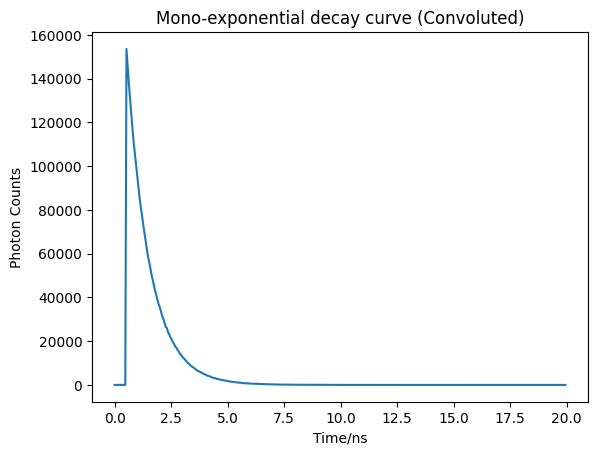

In [5]:
run_time = 20*60
t0 = 10/19 #offset, ns
irfwidth = 1e-5 #IRF Gaussian sigma, ns
tau = [1,3,9] #lifetime array, ns
mono_exp,bins = mono_exp_sim_IRF(tau,run_time , irfwidth)
I = mono_exp[0]
plt.figure()
plt.title('Mono-exponential decay curve (Convoluted)')
plt.plot(bins,I)
plt.xlabel('Time/ns')
plt.ylabel('Photon Counts')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


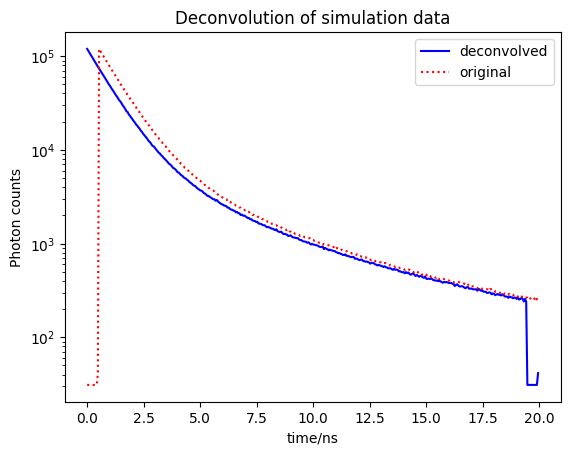

In [6]:
#Deconvolution
t = bins
amp = np.array([0.7,0.2,0.1]) #amplitudes
I = np.dot(amp,mono_exp) #multi-exponential decay
ker = stats.norm.pdf(t,loc = t0, scale = irfwidth) #IRF kernel for deconvolution
#plt.plot(data[:,1])
#plt.plot(x,np.fft.ifft(np.fft.fft(y)/np.fft.fft(ker)))
def deconv_fft(signal,kernel):
    '''Deconvolve decay data with IRF kernel using FFT
    Input:  signal - convolved/original signal (1d array)
            kernel - Gaussian kernel (IRF) (same length as signal)
    Output: deconvolved signal (1d array)'''
    return np.fft.ifft(np.fft.fft(signal)/np.fft.fft(kernel))*np.sum(kernel)
bg_arr = np.full(len(t), int(10*run_time/len(t)))
plt.title('Deconvolution of simulation data')
plt.plot(t,deconv_fft(I,ker),'b',label = 'deconvolved')
plt.plot(t,I,'r:',label = 'original')
plt.xlabel('time/ns')
plt.ylabel('Photon counts')
plt.yscale('log')
plt.legend()

Note near 20ns (the end of the array), the significant drop (especially in multi-exponengtial decays) may be due to boundary effects in FFT transform. May need to trim the data for analysis

In [ ]:
data=groupproject_IRFsimulate([0.8,0.2],[0.4,3],600,0)

In [ ]:
#xpoints = np.linspace(0,1,100)

plt.figure()
plt.title(r'TCSPC data')
plt.xlabel(r'Time / ns')
plt.ylabel(r'Count')
plt.grid()

plt.bar(data[:, 0],data[:, 1])
#plt.plot(data[:, 0],data[:, 1])
#plt.legend(loc="best")

### Monte-Carlo Simulation (No convolution with IRF)

In [ ]:
def multi_exp_sim(t, decay_time_constants, amplitudes):
    decay_profile = np.zeros_like(t)
    for decay_time, amplitude in zip(decay_time_constants, amplitudes):
        decay_profile += amplitude * np.exp(-t / decay_time)
    return decay_profile

# Simulation parameters
t = np.linspace(0, 10, 1000)  # Time points
decay_time_constants = np.array([1.0, 20]) # Decay time constants for each component
amplitudes = np.array([0.8, 0.2])  # Amplitudes for each component

N = 50000  # Number of photons to simulate

# Simulate TCSPC data
timestamps = []
for _ in range(N):
    decay_time = np.random.choice(decay_time_constants, p=amplitudes/np.sum(amplitudes))
    timestamp = np.random.exponential(decay_time)
    timestamps.append(timestamp)

# Histogram the simulated timestamps
counts, bins, _ = plt.hist(timestamps, bins=1000, range=(0, np.max(t)))

# Convert counts to photon counts per time bin
bin_width = bins[1] - bins[0]
photon_counts = counts / (N * bin_width)

# Plot the simulated TCSPC data
plt.xlabel('Time')
plt.ylabel('Photon Counts')
plt.yscale('log')
plt.title('Simulated TCSPC Data')
plt.show()

### Fourier Transform

Simulation Data

In [46]:
bg = 10 #background count per s
bg_arr = np.full(len(mono_exp[0]),int(bg*run_time/len(mono_exp[0])))#bg array to be subtracted
def phasor_fft(amp,tau, run_time, irfwidth):
    '''Generate phasor of multi-exponetial decay curves for an array of lifetimes (n_tau) with corresponding amplitudes
      Photon count rate is 2500 per s
      Input:  amp (1d array of amplitudes of each lifetime component)
              tau (1d array of lifetimes, size = n_tau)
              run_time (in s)
              irfwidth  (sigma of Gaussian IRF)

      output: angular frequency w, phasor (array of complex number, real<->g, -imag <->s coordinate )'''
    exp_arr, t = mono_exp_sim_IRF(tau, run_time, irfwidth) 
    amp = amp/np.sum(amp) #ensure amp sum up to 1
    counts = np.dot(amp,exp_arr)- bg_arr #multi exp decay data - background
    phasor = np.fft.fft(counts)/np.sum(counts)/np.fft.fft(ker)*np.sum(ker)
    freq = np.fft.fftfreq(len(counts), d=20/len(counts))
    w = 2*np.pi*freq #angular frequency
    return w, phasor


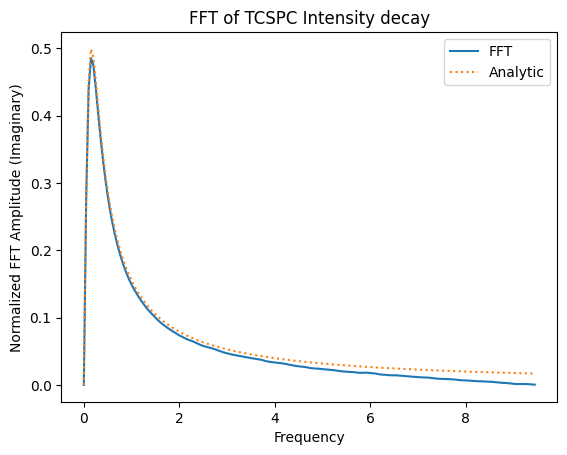

In [75]:
from scipy import integrate
w, demo_phasor = phasor_fft([1],[1], run_time, irfwidth) #Fourier Transform to obtain phasor
W,T = np.meshgrid(w,t)
n_bin = int(len(counts)/2)
freq = w/2/np.pi
plt.plot(freq[:n_bin],-np.imag(demo_phasor)[:n_bin],label = 'FFT')
# plt.plot(freq[:n_bin],np.imag(np.trapz(counts*np.exp(1j*W*T),dx = 20/380,axis = 1)/np.trapz(counts,dx = 20/380)/np.fft.fft(ker)*np.sum(ker))[:n_bin],
# label = 'FT Integral')
# plt.plot(freq, amplitudes[0]/decay_time_constants[0]**2/((freq)**2+(1/decay_time_constants[0])**2)
# +amplitudes[1]/decay_time_constants[1]**2/((freq)**2+(1/decay_time_constants[1])**2),'.')
plt.plot(freq[:n_bin],(w/((w)**2+(1/tau[0])**2))[:n_bin]
,':', label = 'Analytic')
plt.xlabel('Frequency')
plt.ylabel('Normalized FFT Amplitude (Imaginary)')
plt.title('FFT of TCSPC Intensity decay')
plt.legend()

Pure exponential decay, with 100000 data points

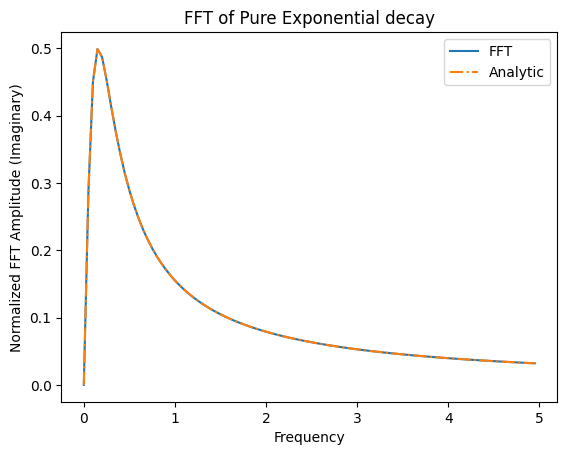

In [8]:
x = np.linspace(0,20,100000)
counts = np.exp(-x)
freq = np.fft.fftfreq(len(counts), d=20/len(counts))
w = 2*np.pi*freq
phasor = np.fft.fft(counts)/np.sum(counts)#/np.fft.fft(ker)*np.sum(ker) #Fourier Transform to obtain phasor
end = int(len(x)/1000)
plt.plot(freq[:end],-np.imag(phasor)[:end],label = 'FFT')
# plt.plot(freq, amplitudes[0]/decay_time_constants[0]**2/((freq)**2+(1/decay_time_constants[0])**2)
# +amplitudes[1]/decay_time_constants[1]**2/((freq)**2+(1/decay_time_constants[1])**2),'.')
plt.plot(freq[:end], (w/((w)**2+(1/tau[0])**2))[:end]
,'-.',label = 'Analytic')
plt.xlabel('Frequency')
plt.ylabel('Normalized FFT Amplitude (Imaginary)')
plt.title('FFT of Pure Exponential decay')
plt.legend()

In [9]:
def phi(tau,omega):
    '''compute phi of phasor from lifetime tau and laser modulation/FT angular frequency omega'''
    return np.arctan(omega*tau)

def m(tau,omega):
    '''compute modulation m of phasor from lifetime tau and laser modulation/FT angular frequency omega'''
    return np.sqrt(1/(1+(omega*tau)**2))

def phasor_coordinate(tau,omega):
    '''convert polar cooridnates m and phi to Cartesian x and y
    output: [x array, y array]'''
    return np.array([m(tau,omega)*np.cos(phi(tau,omega)),m(tau,omega)*np.sin(phi(tau,omega))])

In [ ]:
phasor_coordinate(tau[0],w[4])

### Phasor Plot

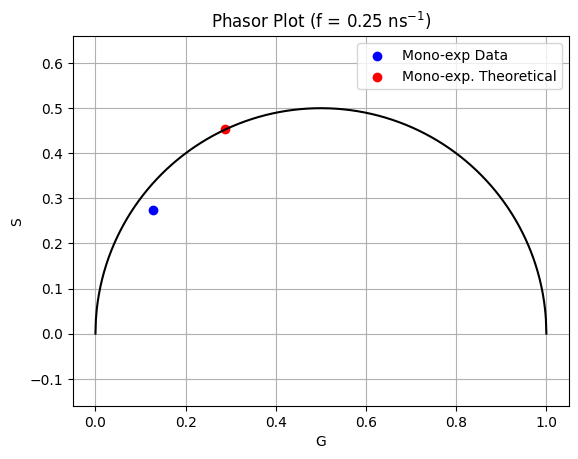

In [21]:
# Phasor plot
x = np.linspace(0,1,1000)
y_circ = np.sqrt(0.5**2-(x-0.5)**2)

plt.figure()
for i in [5] :
    phasor0 = phasor[i]
    w0 = w[i]
    plt.scatter(np.real(phasor0), -np.imag(phasor0), c='blue', label = 'Mono-exp Data')
    plt.scatter(phasor_coordinate(tau[0],w0)[0],phasor_coordinate(tau[0],w0)[1], c='red',label = 'Mono-exp. Theoretical')
    # plt.scatter(np.sum(amplitudes * phasor_coordinate(decay_time_constants,omegas)[0]),
    # np.sum(amplitudes * phasor_coordinate(decay_time_constants,omegas)[1]), c='green',label = 'True')
    plt.plot(x,y_circ,'k') #universal circle
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('G')
    plt.ylabel('S')
    plt.title(f'Phasor Plot (f = {freq[i]}'+r' ns$^{-1}$)')
    plt.axis('equal')
    plt.grid()
    plt.legend()
    #decomposition assuming equal contribution
    # plt.plot(RT1[0],RT1[1],'.')
    # plt.plot(RT2[0],RT2[1],'.')
    # plt.plot((RT1[0]+RT2[0])/2, (RT1+RT2)[1]/2,'x')

Note that the transformed data does not lies exactly on universal circle. \
This may be due to: noise, inaccurate deconvolution due to finite array size & step \
Especially when the phasor is obtained by Fast Fourier Transform (FFT) (a kind of DiscreteFourier transform),\
this may differ from the analytic solution

### Decomposition of Bi-exponential decay

System of equation:
$$\begin{array}{c}
f_i g_i(\omega_j) = G_j\\
f_i s_i(\omega_j) = S_j\\
\end{array}
$$

$G_j$ and $S_j$ are phasor coordinates (xy) of actual data.\
$g_i$ and $s_i$ are $i^{\text{th}}$ phasor coordinates (xy) of single exponential component\
$\omega_j$ is the FFT angular frequency used

The codes below only uses $g$ coordinate

In [15]:
from sympy import symbols, solve, Eq, Function
from sympy.matrices import Matrix
import sympy as sp
# n = 2 #no. of exp
# f1,f2,tau1,tau2,w1,w2,w3,w4= symbols('f1,f2,tau1,tau2,w1,w2,w3,w4') #meshgrid of tau*w

# def g(tau,w):
#     '''g coordinate of phasor plot'''
#     phi = sp.atan(tau*w)
#     m = 1/(1+(tau*w)**2)**(1/2)
#     return m*sp.cos(phi) 
# f = Matrix([f1,f2]) #
# g_data = Matrix(symbols('G0:%d' % 4))
# #w = Matrix(symbols('w0:%d' % n))
# M = Matrix([[g(tau1,w1),g(tau2,w1)],
#             [g(tau1,w2),g(tau2,w2)], 
#             [g(tau1,w3),g(tau2,w3)],
#             [g(tau1,w4),g(tau2,w4)]])
# solve(M*f -g_data, (tau1,tau2,f1,f2))

In [ ]:
freq[8]

In [ ]:
np.real(phasor)[[2,4,8]]

In [14]:
w[[2,4,8]]

array([0.62831853, 1.25663706, 2.51327412])

Solving for lifetimes  and fractional intensities using phasors of multiple frequencies
for 2n variables (n: no. of lifetimes), need to use 2n-1 frequencies to give 

NOTE: RUN-TIME FOR DECOMPOSING 3 COMPONENT EXP DECA IS VERY LONG (too long that I keyboard-interrupted it) 
Solving for 2 component is reasonably fast

In [ ]:
from sympy import symbols, Eq, solve
n = 3
# Define the variables and symbols
f = symbols('f1:%d' % (n+1))
t = symbols('t1:%d' % (n+1))

equations = [sum([f[j]for j in range(n)])-1]

# Generate the equations
for i in [1,2,3,4,8]:
    equation = sum([f[j] / ((w[i] * t[j])**2 + 1) for j in range(n)]) - np.real(phasor)[i] #g coordinate of phasor
    equations.append(equation)

# Solve the system of equations
solution = solve(equations, f[0], f[1],f[2], t[0], t[1],t[2])

solution

Solving for bi-exponential decay

In [67]:
from sympy import symbols, Eq, solve
w, phasor = phasor_fft([0.4,0.6],[1,2],run_time,irfwidth)

def phasor_solve(w,phasor,n=2):
    '''Solve for fractional intensities and lifetimes from simulated phasor coordinates
       Input: w        angular frequency array
              phasor   output from phasor_fft
              n        number of components (Default 2)'''
    # Define the variables and symbols
    f = symbols('f1:%d' % (n+1)) #fractional intensities
    t = symbols('t1:%d' % (n+1)) #lifetimes

    equations = [sum([f[j]for j in range(n)])-1]

    # Generate the equations using different angular frequencies
    for i in range(1,2*n):
        equation = sum([f[j] / ((w[i] * t[j])**2 + 1) for j in range(n)]) - np.real(phasor)[i] #g coordinate of phasor
        equations.append(equation)

    # Solve the system of equations
    solution = solve(equations)
    return solution[0]


In [68]:
w, phasor_NADH = phasor_fft([0.75,0.25],[0.4,4],run_time,irfwidth)
w, phasor_EGFP = phasor_fft([0.503,0.497],[3.07,2.43],run_time,irfwidth)
w, phasor_mCherry = phasor_fft([0.83,0.17],[1.43,2.38],run_time,irfwidth)

In [72]:
phasor_dict = {'NADH':phasor_NADH,'EGFP':phasor_EGFP,'mCherry':phasor_mCherry}
sol = {'NADH':0, 'EGFP':0,'mCherry':0}
for key,val in phasor_dict.items():
     sol[key] = phasor_solve(w,val,n=2)


In [73]:
sol

{'NADH': {f1: 0.247768682916999,
  f2: 0.752231317083001,
  t1: -3.99692120249365,
  t2: -0.383727981676267},
 'EGFP': {f1: 0.0312002240771287,
  f2: 0.968799775922871,
  t1: -0.909714272897448,
  t2: -2.77867484456820},
 'mCherry': {f1: 0.465261403266904,
  f2: 0.534738596733096,
  t1: -1.18719232006951,
  t2: -1.90012803094180}}

In [ ]:
from sympy import symbols, solve

def decomBiexp(g, s, w):
    ''' For a bi-exponential decay phasor, assume that the INTENSITY CONTRIBUTION 
      of the two lifetime components are the same, and do the decomposition of
      the phasor and obtain the two single exponential decay components.
       g is the x-axis coordinate of the mixture phasor.
       s is the y-axis coordinate of the mixture phasor.  
       w is the laser frequency (Fourier transform frequency'''
    # Define symbolic variables
    a, b, root1, root2 = symbols('a b root1 root2')

    # Calculate the roots of the line connecting the two phasor coordinates
    b = s - a * g
    root1 = (1 - 2 * a * b + (1 - 4 * a * b - 4 * b**2)**(1/2)) / (2 * (a**2 + 1))
    root2 = (1 - 2 * a * b - (1 - 4 * a * b - 4 * b**2)**(1/2)) / (2 * (a**2 + 1))

    # Solve for the coefficient 'a'
    A = solve([root1 - g - (g - root2)], 'a')
    A = [float(val[a]) for val in A]

    # Calculate the coefficient 'b'
    B = s - np.array(A) * g

    # Calculate the coordinates of the roots
    rt1 = np.zeros((2, len(A)))
    rt2 = np.zeros((2, len(A)))
    for i, val in enumerate(A):
        rt1[0, i] = (1 - 2 * val * B[i] + (1 - 4 * val * B[i] - 4 * B[i]**2)**(1/2)) / (2 * (val**2 + 1))
        rt1[1, i] = val * rt1[0, i] + B[i]
        rt2[0, i] = (1 - 2 * val * B[i] - (1 - 4 * val * B[i] - 4 * B[i]**2)**(1/2)) / (2 * (val**2 + 1))
        rt2[1, i] = val * rt2[0, i] + B[i]

    # Select the appropriate roots and coefficients based on conditions
    if rt1[1, 0] > 0 and rt2[1, 0] > 0:
        RT1 = rt1[:, 0]
        RT2 = rt2[:, 0]
        Af = A[0]
        Bf = B[0]
    else:
        RT1 = rt1[:, 1]
        RT2 = rt2[:, 1]
        Af = A[1]
        Bf = B[1]

    # Calculate the lifetimes
    tau1 = RT1[1] / (RT1[0] * w)
    tau2 = RT2[1] / (RT2[0] * w)

    return Af, Bf, RT1, RT2, tau1, tau2

In [ ]:
Af, Bf, RT1, RT2, tau1, tau2 = decomBiexp(np.real(phasor), -np.imag(phasor), 0.6*np.pi)

In [ ]:
a, b, root1, root2 = symbols('a b root1 root2')
s =-np.imag(phasor)
g = np.real(phasor)
# Calculate the roots of the line connecting the two phasor coordinates
b =  s - a * g
root1 = (1 - 2 * a * b + (1 - 4 * a * b - 4 * b**2)**(1/2)) / (2 * (a**2 + 1))
root2 = (1 - 2 * a * b - (1 - 4 * a * b - 4 * b**2)**(1/2)) / (2 * (a**2 + 1))
A = solve([root1 - g - (g - root2)], 'a')
A = [float(val[a]) for val in A]

In [ ]:
Af+Bf

In [ ]:
amplitudes

In [ ]:
from sympy import symbols, Eq, solve

x, y, a, b, g, s = symbols('x y a b g s')

# Define the equations
eq1 = Eq(y, a*x + b)
eq2 = Eq((x - 0.5)**2 + y**2, 0.5**2)
eq3 = Eq(s, a*g + b)
# Solve the system of equations
r1,r2 = solve((eq1, eq2), (x, y))
eq4 = Eq(a, (r1[1]-r2[1])/(r1[0]-r2[0]))
a,b = solve((eq3,eq4),(a,b))

# Print the solution
print(r1)

In [ ]:
solve((eq3,eq4),(a,b))


### Convolution and de-convolution using FFT

In [ ]:
from scipy import signal
from scipy.signal import butter, filtfilt
# Example data
x = np.linspace(0, 10, 1000)
original_signal = np.exp(-x)  # Original signal
kernel = np.exp(-(x - 3)**2 / 0.0005)  # Kernel
kernel = kernel/np.sum(kernel)
#result_signal = np.fft.ifft(np.fft.fft(original_signal)*np.fft.fft(kernel))/np.sum(kernel)
result_signal = signal.convolve(kernel,original_signal)[:1000]

# Perform Fourier transforms
signal_freq = np.fft.fft(result_signal)
kernel_freq = np.fft.fft(kernel)

# Deconvolve in the frequency domain
deconvolved_freq = signal_freq/kernel_freq

# Inverse Fourier transform to obtain the deconvolved signal
deconvolved_signal = np.fft.ifft(deconvolved_freq)*np.sum(kernel)

# Plot the original signal, kernel, and deconvolved signal
plt.figure(figsize=(6, 10))
plt.subplot(3, 1, 1)
plt.plot(x, original_signal, label = 'true signal')
plt.plot(x, result_signal,label = 'convolved')
plt.title('Original Signal')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(x, kernel)
plt.title('Kernel')

plt.subplot(3, 1, 3)
plt.plot(x, deconvolved_signal)
plt.title('Deconvolved Signal')

plt.tight_layout()
plt.show()

In [ ]:
high_freq_cutoff = np.ones(1000)
high_freq_cutoff[350:650] = np.ones(650-350)*0.4
deconv = np.fft.fft(signal.convolve(kernel,original_signal)[:1000])/np.fft.fft(kernel)
deconv[350:650] = np.ones(650-350)*0.4
#plt.plot(np.fft.fft(original_signal))
plt.plot(np.fft.ifft(deconv),':')
#plt.plot(1/np.fft.fft(kernel)*np.sum(np.fft.fft(kernel)),':')

In [ ]:
t0 = 10/19
irf_width = 0.005
data = groupproject_IRFsimulate([1],[4],1000,irf_width)
x = data[:,0]
y = data[:,1] 
ker = np.max(y)*stats.norm.pdf(x,loc = t0, scale = irf_width)
#plt.plot(data[:,1])
#plt.plot(x,np.fft.ifft(np.fft.fft(y)/np.fft.fft(ker)))
plt.title('Deconvolution of simulation data')
plt.plot(x,np.fft.ifft(np.fft.fft(y)/np.fft.fft(ker))*np.sum(ker),label = 'deconvolved')
plt.plot(x,y,label = 'original')
plt.xlabel('time/ns')
plt.ylabel('Photon counts')
plt.legend()